# State-specific LSTM model
This notebook includes code to evaluate LSTM model transferability and sensitivity to training data through the training and evaluation of a state-specific LSTM model. The first section of the code trains an LSTM model on data from Colorado and the second section of the code evaluates the model's performance on a set of national test sites. 

In [2]:
## PRELIMINARIES ##
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import random as rn
import pickle
import traceback
import torch
from mpl_toolkits.basemap import Basemap
import geopandas as gpd
from collections import defaultdict
from matplotlib.collections import LineCollection

from _lstm import *
from _data import *

import io
from contextlib import redirect_stdout
trap = io.StringIO()

## Train model
Train LSTM model on regionally-specific dataset that includes only sites from Colorado.

In [3]:
## GET TRAINING SITES FOR COLORADO ##
# there are 95 sites with more than 9 years of data that are not in the national testing dataset
num_years = 9

snotel = hf.get_site_variables(variable="swe", state='CO')
snotel = snotel.reset_index(drop=True).drop(columns=['variable_name','units','site_query_url','date_metadata_last_updated','tz_cd','doi'])

# read in testing data and remove it from dataset
data_test = pd.read_csv('national_test_sites.txt', sep=' ',header=None)
data_test.columns = ['site_id', 'site_name', 'site_type', 'agency', 'state','first_date_data_available', 'last_date_data_available', 'record_count',
                     'latitude', 'longitude', 'bins', 'first_wy_date', 'last_wy_date']
data_test = data_test.drop(columns=['bins', 'first_wy_date', 'last_wy_date'])
snotel = snotel[~snotel['site_id'].isin(data_test['site_id'])].reset_index(drop=True)

snotel['first_wy_date'] = snotel.apply(lambda x: get_wy_start(pd.to_datetime(x.first_date_data_available), x.site_id), axis=1)
snotel['last_wy_date'] = snotel.apply(lambda x: get_wy_end(pd.to_datetime(x.last_date_data_available), x.site_id), axis=1)
snotel = snotel.dropna(axis='index', subset=['first_wy_date','last_wy_date'], how='any').reset_index(drop=True)

snotel['num years'] = np.array(list(int(x.split('-')[0]) for x in snotel['last_wy_date'])) - np.array(list(int(x.split('-')[0]) for x in snotel['first_wy_date']))
snotel = snotel[snotel['num years'] >= num_years].reset_index(drop=True)

In [13]:
## GET TRAINING/TESTING DATA ##
data = pd.DataFrame(columns=['site_id', 'year','train'])

for i in range(0, len(snotel)):
    site_id = snotel['site_id'][i]
    start_date = snotel['first_wy_date'][i]
    end_date = snotel['last_wy_date'][i]
    try:
        with redirect_stdout(trap):
            years = get_years_precip(start_date, end_date, site_id, num_years) 

        for j in range(0, len(years)):
            # alternate sites for training and testing data
            #if ((i%2) == 0):
            data.loc[len(data.index)] = [site_id, int(years[j]), True] 
            #else:
                #data.loc[len(data.index)] = [site_id, int(years[j]), False] 
    except:
        print('missing data for ', site_id)
        traceback.print_exc()

# get data for each year in training and testing set
l_swe_train = [] 
l_non_swe_train = []
l_swe_test = [] 
l_non_swe_test = []

data_train = data.loc[(data.loc[:,'train'] == True)].reset_index().drop(columns=['index','train'])
data_test = pd.read_csv('national_test_years.txt', sep=' ',header=None)
data_test.columns = ['site_id',	'year',	'train']
#data_test = data.loc[(data.loc[:,'train'] == False)].reset_index().drop(columns=['index','train'])

## GET TRAINING DATA ##
for j in range(0,len(data_train)):
    site_id = data_train['site_id'][j]
    year = data_train['year'][j]
    start_date = str(year-1) + '-10-01'
    end_date = str(year) + '-09-30'
    try:
        with redirect_stdout(trap):
            swe, non_swe = get_sc_data(site_id, start_date, end_date)
        l_swe_train.append(swe)
        l_non_swe_train.append(non_swe)

        # add site data
        data_train.loc[j, 'latitude'] = non_swe['latitude'][0]
        data_train.loc[j, 'longitude'] = non_swe['longitude'][0]
        data_train.loc[j, 'elevation'] = non_swe['elevation'][0]
        data_train.loc[j, 'land cover'] = non_swe['land_cover'][0]
        data_train.loc[j, 'slope_x'] = non_swe['slope_x'][0]
        data_train.loc[j, 'slope_y'] = non_swe['slope_y'][0] 
    except:
        print('missing data for ', site_id, " : ", year)
        traceback.print_exc()

## GET TESTING DATA ##
for j in range(0, len(data_test)):
    site_id = data_test['site_id'][j]
    year = data_test['year'][j]
    start_date = str(year-1) + '-10-01'
    end_date = str(year) + '-09-30'
    try:
        with redirect_stdout(trap):
            swe, non_swe = get_sc_data(site_id, start_date, end_date)
        l_swe_test.append(swe)
        l_non_swe_test.append(non_swe)

        # add site data
        data_test.loc[j, 'latitude'] = non_swe.loc[0,'latitude']
        data_test.loc[j, 'longitude'] = non_swe.loc[0,'longitude']
        data_test.loc[j, 'elevation'] = non_swe.loc[0,'elevation']
        data_test.loc[j, 'land cover'] = non_swe.loc[0,'land_cover']
        data_test.loc[j, 'slope_x'] = non_swe.loc[0,'slope_x']
        data_test.loc[j, 'slope_y'] = non_swe.loc[0,'slope_y']
    except:
        print('missing data for ', site_id, " : ", year)
        traceback.print_exc()


## SAVE METADATA ##
data_train.to_csv('Data/LSTM_output/CO_regional_train_metadata.csv',sep=' ', index=False)
data_test.to_csv('Data/LSTM_output/CO_regional_test_metadata.csv',sep=' ', index=False)


## MODEL INPUT ##
train_swe = pd.concat(l_swe_train).reset_index().drop(columns='index')
train_non_swe = pd.concat(l_non_swe_train).reset_index().drop(columns='index')

test_swe = pd.concat(l_swe_test).reset_index().drop(columns='index')
test_non_swe = pd.concat(l_non_swe_test).reset_index().drop(columns='index')

# generate normalization, based on training data
l_normalize = create_normalization(train_swe, train_non_swe)
scaler_swe = l_normalize[0]
with open("Data/LSTM_output/CO_regional_normalize.pkl" , 'wb') as file:  
    pickle.dump(l_normalize, file)

# generate input for model
train_swe_tensors, train_non_swe_tensors, train_sites, train_years = create_dataset(train_swe, train_non_swe, l_normalize)
test_swe_tensors, test_non_swe_tensors, test_sites, test_years = create_dataset(test_swe, test_non_swe, l_normalize)
torch.save(train_swe_tensors, 'Data/LSTM_output/CO_regional_train_swe.pt')
torch.save(train_non_swe_tensors, 'Data/LSTM_output/CO_regional_train_non_swe.pt')
torch.save(test_swe_tensors, 'Data/LSTM_output/CO_regional_test_swe.pt')
torch.save(test_non_swe_tensors, 'Data/LSTM_output/CO_regional_test_non_swe.pt')


## ESTABLISH MODEL ##
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
lstm = LSTM(input_size, batch_size, output_size, hidden_size, num_layers)
lstm = lstm.to(DEVICE)
train_swe_tensors = train_swe_tensors.to(DEVICE)
train_non_swe_tensors = train_non_swe_tensors.to(DEVICE)
test_swe_tensors = test_swe_tensors.to(DEVICE)
test_non_swe_tensors = test_non_swe_tensors.to(DEVICE)


## TRAIN MODEL ##
loss_record = train_lstm(lstm, train_swe_tensors, train_non_swe_tensors, test_swe_tensors, test_non_swe_tensors)
# val_record


## SAVE MODEL TO PICKLE ##
torch.save(lstm, 'Data/LSTM_output/CO_regional_lstm.pt')


## EVALUATE LSTM ##
ev_lstm = torch.load('Data/LSTM_output/CO_regional_lstm.pt', map_location = DEVICE)
ev_test_swe = torch.load('Data/LSTM_output/CO_regional_test_swe.pt')
ev_test_non_swe = torch.load('Data/LSTM_output/CO_regional_test_non_swe.pt')

statistics, feature_importance = analyze_results_lstm(ev_lstm, data_test, ev_test_swe, ev_test_non_swe, scaler_swe, False)
print('statistics for CO Region')
print(f"RMSE: {np.mean(statistics['rmse']):.2f}")
print(f"normal RMSE: {np.mean(statistics['normal rmse']):.2f}")
print(f"NSE: {np.mean(statistics['nse']):.2f}")
print(f"R2: {np.mean(statistics['r2']):.2f}")
print(f"Spearman's rho: {np.mean(statistics['spearman_rho']):.2f}")
print(f"delta peak SWE: {np.mean(statistics['delta peak']):.2f}")
print(f"normal delta peak SWE: {np.mean(statistics['normal delta peak']):.2f}")
print(f"absolute delta peak SWE: {np.mean(statistics['abs delta peak']):.2f}")
print(f"normal absolute delta peak SWE: {np.mean(statistics['normal abs delta peak']):.2f}")
print(f"delta days: {np.mean(statistics['delta days']):.2f}")
print(f"absolute delta days: {np.mean(statistics['abs delta days']):.2f}")

# save feature importance and statistics
feature_importance = pd.DataFrame(feature_importance)
feature_importance.to_csv('Data/LSTM_output/CO_regional_features.txt',sep=' ',header=None, index=False, index_label=False)
statistics.to_csv('Data/LSTM_output/CO_regional_statistics.txt',sep=' ',header=None, index=False, index_label=False)

missing data for  1185:CO:SNTL


Traceback (most recent call last):
  File "/tmp/ipykernel_2471937/2668886684.py", line 10, in <module>
    years = get_years_precip(start_date, end_date, site_id, num_years)
  File "/home/mcburns/national_lstm/_data.py", line 620, in get_years_precip
    avg_i = rn.sample(peak_values.loc[peak_values['bins'] == 'avg'].index.to_list(), sample_size)
  File "/home/mcburns/.conda/envs/thesis/lib/python3.9/random.py", line 449, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


missing data for  1252:CO:SNTL


Traceback (most recent call last):
  File "/tmp/ipykernel_2471937/2668886684.py", line 10, in <module>
    years = get_years_precip(start_date, end_date, site_id, num_years)
  File "/home/mcburns/national_lstm/_data.py", line 619, in get_years_precip
    abv_avg_i = rn.sample(peak_values.loc[peak_values['bins'] == 'above avg'].index.to_list(), sample_size)
  File "/home/mcburns/.conda/envs/thesis/lib/python3.9/random.py", line 449, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative


missing data for  1251:CO:SNTL


Traceback (most recent call last):
  File "/tmp/ipykernel_2471937/2668886684.py", line 10, in <module>
    years = get_years_precip(start_date, end_date, site_id, num_years)
  File "/home/mcburns/national_lstm/_data.py", line 620, in get_years_precip
    avg_i = rn.sample(peak_values.loc[peak_values['bins'] == 'avg'].index.to_list(), sample_size)
  File "/home/mcburns/.conda/envs/thesis/lib/python3.9/random.py", line 449, in sample
    raise ValueError("Sample larger than population or is negative")
ValueError: Sample larger than population or is negative
/home/mcburns/.conda/envs/thesis/lib/python3.9/site-packages/hf_hydrodata/data_model_access.py:349: UserWarning: Warning - unable to update model from API (no internet access?) using 'https://hydrogen.princeton.edu/api/config/data_catalog_model?version=1.0.3'
  warn(
  0%|          | 1/2500 [00:21<14:55:54, 21.51s/it]

Epoch: 0, loss: 0.00597


 20%|██        | 501/2500 [2:46:56<10:21:58, 18.67s/it]

Epoch: 500, loss: 0.00044


 40%|████      | 1001/2500 [5:27:38<8:19:46, 20.00s/it]

Epoch: 1000, loss: 0.00031


 60%|██████    | 1501/2500 [8:21:57<5:26:38, 19.62s/it]   

Epoch: 1500, loss: 0.00015


 80%|████████  | 2001/2500 [11:03:34<2:39:54, 19.23s/it]

Epoch: 2000, loss: 0.00007


100%|██████████| 2500/2500 [13:47:04<00:00, 19.85s/it]  
/tmp/ipykernel_2471937/2668886684.py:127: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ev_lstm = torch.load('Data/L

statistics for CO Region
RMSE: 98.07
normal RMSE: 0.24
NSE: -1.99
R2: -1.99
Spearman's rho: 0.81
delta peak SWE: -60.73
normal delta peak SWE: -0.15
absolute delta peak SWE: 137.19
normal absolute delta peak SWE: 0.37
delta days: 0.28
absolute delta days: 20.33


## Evaluate model accuracy

In [3]:
## READ DATA IN ##
test_sites = pd.read_csv('national_test_sites.txt', sep=' ', header=None)
test_sites.columns = ['site_id', 'site_name', 'site_type', 'agency', 'state','first_date_data_available', 'last_date_data_available', 'record_count',
                     'latitude', 'longitude', 'bins','first_wy_date', 'last_wy_date']
test_metadata = pd.read_csv('Data/LSTM_output/test_metadata.csv', sep=' ',header=None)
test_metadata.columns = ['site_id','year','train','latitude','longitude','elevation','land_cover','slope_x','slope_y']

# read LSTM metrics
lstm_results = pd.read_csv('Data/LSTM_output/CO_regional_statistics.txt', sep=' ', header=None)
lstm_results.columns = ['rmse', 'normal rmse', 'nse', 'r2', 'spearman_rho', 'delta peak','normal delta peak', 'abs delta peak', 
               'normal abs delta peak','delta days', 'abs delta days']
lstm_results = pd.concat([lstm_results, test_metadata], axis=1)
lstm_results_agg = lstm_results.groupby('site_id').median().reset_index()
lstm_results_agg['state'] = np.array(x.split(':')[1] for x in lstm_results_agg['site_id'])

In [10]:
## PREDICTIONS BY STATE ##
# divide by location
co = lstm_results_agg[lstm_results_agg['state']=='CO']
maritime = pd.concat([lstm_results_agg[lstm_results_agg.state == 'WA'], lstm_results_agg[lstm_results_agg.state == 'OR'], lstm_results_agg[lstm_results_agg.state == 'CA']]).reset_index()
intermountain = pd.concat([lstm_results_agg[lstm_results_agg.state == 'MT'], lstm_results_agg[lstm_results_agg.state == 'UT'], lstm_results_agg[lstm_results_agg.state == 'ID'], lstm_results_agg[lstm_results_agg.state == 'NV']])
continental = pd.concat([lstm_results_agg[lstm_results_agg.state == 'CO'], lstm_results_agg[lstm_results_agg.state == 'NM'], lstm_results_agg[lstm_results_agg.state == 'AZ'], lstm_results_agg[lstm_results_agg.state == 'WY']])

# mean statistics
print('MEAN \nRMSE for maritime', np.mean(maritime['rmse']))
print('RMSE for intermountain', np.mean(intermountain['rmse']))
print('RMSE for continental', np.mean(continental['rmse']))
print('RMSE for Colorado', np.mean(co['rmse']))

print('\nNSE for maritime', np.mean(maritime['nse']))
print('NSE for intermountain', np.mean(intermountain['nse']))
print('NSE for continental', np.mean(continental['nse']))
print('NSE for Colorado', np.mean(co['nse']))

print('\nabs delta days for maritime', np.mean(maritime['abs delta days']))
print('abs delta days for intermountain', np.mean(intermountain['abs delta days']))
print('abs delta days for continental', np.mean(continental['abs delta days']))
print('abs delta days for Colorado', np.mean(co['abs delta days']))

print('\nMEDIAN \nRMSE for maritime', np.median(maritime['rmse']))
print('RMSE for intermountain', np.median(intermountain['rmse']))
print('RMSE for continental', np.median(continental['rmse']))
print('RMSE for Colorado', np.median(co['rmse']))

print('\nNSE for maritime', np.median(maritime['nse']))
print('NSE for intermountain', np.median(intermountain['nse']))
print('NSE for continental', np.median(continental['nse']))
print('NSE for Colorado', np.median(co['nse']))

print('\nabs delta days for maritime', np.median(maritime['abs delta days']))
print('abs delta days for intermountain', np.median(intermountain['abs delta days']))
print('abs delta days for continental', np.median(continental['abs delta days']))
print('abs delta days for Colorado', np.median(co['abs delta days']))

MEAN 
RMSE for maritime 141.9438552260399
RMSE for intermountain 75.27360818192766
RMSE for continental 67.72413849830627
RMSE for Colorado 69.82499737209744

NSE for maritime -0.07906427374109626
NSE for intermountain 0.636165290466837
NSE for continental 0.6575440096203238
NSE for Colorado 0.7489149328321218

abs delta days for maritime 25.90625
abs delta days for intermountain 13.297297297297296
abs delta days for continental 13.625
abs delta days for Colorado 12.055555555555555

MEDIAN 
RMSE for maritime 132.10890197753906
RMSE for intermountain 66.21834564208984
RMSE for continental 58.977149963378906
RMSE for Colorado 58.977149963378906

NSE for maritime 0.2464999258518219
NSE for intermountain 0.6689669489860535
NSE for continental 0.8270024359226227
NSE for Colorado 0.8972976766526699

abs delta days for maritime 20.5
abs delta days for intermountain 13.0
abs delta days for continental 10.5
abs delta days for Colorado 10.5


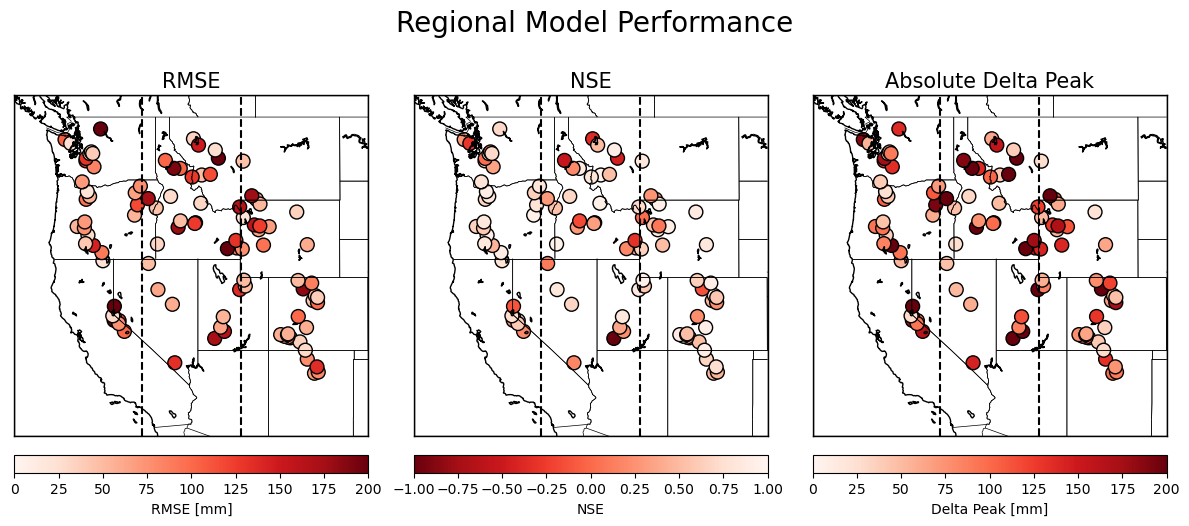

In [5]:
## MAP OF MODEL PERFORMANCE - SITE ##
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 10))

# coordinates are the same across all aggregated sites
m = Basemap(projection='merc', llcrnrlon=-127, llcrnrlat=32, urcrnrlon=-102, urcrnrlat=50, resolution='i')
x, y = m(test_sites['longitude'].values, test_sites['latitude'].values)
#x, y = map(test_sites['longitude'], test_sites['latitude'])

# plot RMSE
m = Basemap(projection='merc', llcrnrlon=-127,llcrnrlat=32,urcrnrlon=-102,urcrnrlat=50, resolution = 'i', ax=axes[0])
m.drawmapboundary()
m.drawcountries()
m.drawcoastlines()
m.drawstates()
axes[0].axvline(m(-118, 0)[0], linestyle='--', color='black')
axes[0].axvline(m(-111, 0)[0], linestyle='--', color='black')
sc1 = m.scatter(x, y, c=lstm_results_agg['rmse'], cmap='Reds', vmin=0, vmax=200, marker='o', s=100, edgecolor='k')
axes[0].set_title('RMSE', fontsize=15)
cbar1 = fig.colorbar(sc1, ax=axes[0], orientation='horizontal', pad=0.02)
cbar1.set_label('RMSE [mm]')

# plot NSE
m = Basemap(projection='merc', llcrnrlon=-127,llcrnrlat=32,urcrnrlon=-102,urcrnrlat=50, resolution = 'i', ax=axes[1])
m.drawmapboundary()
m.drawcountries()
m.drawcoastlines()
m.drawstates()
axes[1].axvline(m(-118, 0)[0], linestyle='--', color='black')
axes[1].axvline(m(-111, 0)[0], linestyle='--', color='black')
sc2 = m.scatter(x, y, c=lstm_results_agg['nse'], cmap='Reds_r', vmin=-1, vmax=1, marker='o', s=100, edgecolor='k')
axes[1].set_title('NSE', fontsize=15)
cbar1 = fig.colorbar(sc2, ax=axes[1], orientation='horizontal', pad=0.02)
cbar1.set_label('NSE')

# plot delta peak
m = Basemap(projection='merc', llcrnrlon=-127,llcrnrlat=32,urcrnrlon=-102,urcrnrlat=50, resolution = 'i', ax=axes[2])
m.drawmapboundary()
m.drawcountries()
m.drawcoastlines()
m.drawstates()
axes[2].axvline(m(-118, 0)[0], linestyle='--', color='black')
axes[2].axvline(m(-111, 0)[0], linestyle='--', color='black')
sc3 = m.scatter(x, y, c=lstm_results_agg['abs delta peak'], cmap='Reds', vmin=0, vmax=200, marker='o', s=100, edgecolor='k')
axes[2].set_title('Absolute Delta Peak', fontsize=15)
cbar1 = fig.colorbar(sc3, ax=axes[2], orientation='horizontal', pad=0.02)
cbar1.set_label('Delta Peak [mm]')

# plot things
fig.suptitle('Regional Model Performance', fontsize=20, y=0.6)
plt.tight_layout() 

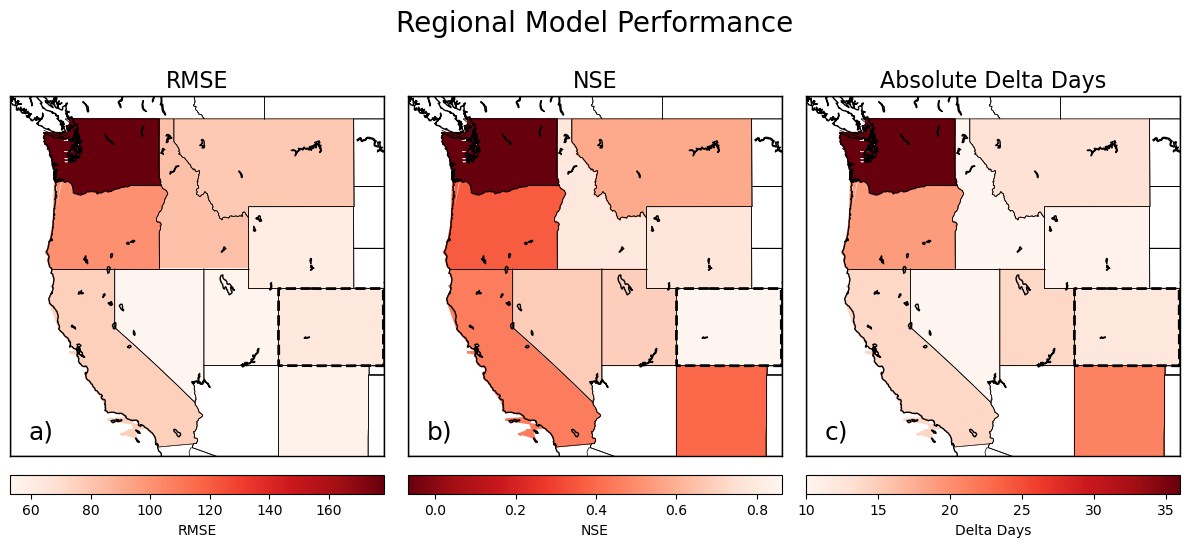

In [5]:
## MAP OF MODEL PERFORMANCE - STATE ##
# aggregate data by state
lstm_results['state'] = np.array(x.split(':')[1] for x in lstm_results['site_id'])
lstm_results_agg_state = lstm_results.drop(columns=['site_id','year','train']).groupby('state').median().reset_index()

# define metric
metric='nse'

# plot
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 10))
metrics = ['rmse','nse','abs delta days']
labels = ['a)','b)','c)']

for i in range(0,len(metrics)): 
    metric = metrics[i]

    # create basemap
    m = Basemap(projection='merc', llcrnrlon=-127, llcrnrlat=32, urcrnrlon=-102, urcrnrlat=50, resolution='i', ax=axes[i])
    m.readshapefile('Data/us_state_shapefile/s_05mr24', name='STATE', drawbounds=True)

    # Loop through state_info to gather all polygons for each state
    state_polygons = defaultdict(list)
    for shape_dict, shape in zip(m.STATE_info, m.STATE):
       state_name = shape_dict['STATE']  # or the appropriate attribute for state name
       state_polygons[state_name].append(np.array(shape))  # Aggregate coordinates for the state

    # Create a color map based on accuracy
    norm = plt.Normalize(lstm_results_agg_state[metric].min(), lstm_results_agg_state[metric].max())
    if metric=='nse':
        cmap = plt.get_cmap('Reds_r')
    else:
        cmap = plt.get_cmap('Reds')

    # Shade states based on average accuracy
    patches = []
    for state_name, polygons in state_polygons.items():
        if state_name in lstm_results_agg_state['state'].values:
            accuracy_value = lstm_results_agg_state.loc[lstm_results_agg_state['state'] == state_name, metric].values[0]
            color = cmap(norm(accuracy_value))
            
            #for polygon in polygons:
            merged_coords = np.vstack(polygons)  # Merge the list of arrays into one array
            if state_name=='CO':
                patches.append(Polygon(merged_coords, closed=True, facecolor=color, edgecolor="black"))
                outline = LineCollection([merged_coords], colors="black", linewidths=2, linestyles="--")
            patches.append(Polygon(merged_coords, closed=True, facecolor=color, edgecolor=color))
    
    axes[i].add_collection(PatchCollection(patches, match_original=True, zorder=2))
    axes[i].add_collection(outline)
    axes[i].text(0.05, 0.05, labels[i], fontsize=18, transform=axes[i].transAxes)
    m.drawmapboundary()
    m.drawcountries()
    m.drawcoastlines()
    m.drawstates()
    
    # individual plot things
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axes[i], orientation='horizontal', pad=0.02)
    if metric=='abs delta days':
        axes[i].set_title('Absolute Delta Days', fontsize=16)
        cbar.set_label('Delta Days')
    else:
        axes[i].set_title(metric.upper(), fontsize=16)
        cbar.set_label(metric.upper())

# plot things
fig.suptitle('Regional Model Performance', fontsize=20, y=0.62)
plt.tight_layout() 